In [110]:
import matplotlib.pyplot as plt
import nibabel
import numpy as np
import pandas as pd
from pathlib import Path
from skimage.transform import rescale
from tqdm import tqdm
import os
import researchpy

In [161]:
import scipy
def compute_kl(img, brain, mask, _bin_heuristics = 'sturges'):
    size, _bins = np.histogram(img[brain.astype(bool)], bins = _bin_heuristics)
    bins = [(_bins[i]+_bins[i+1])/2 for i in range(len(_bins)-1)]
    # WT
    #size_healthy, bin_edges = np.histogram(img[brain.astype(bool)^mask.astype(bool)].reshape(-1), bins=_bins)
    # TC
    size_healthy, bin_edges = np.histogram(img[brain.astype(bool)^(mask == 2)].reshape(-1), bins=_bins)
    # ET
    size_tumor, _ = np.histogram(img[mask.astype(bool)].reshape(-1), bins = _bins)

    size_healthy = np.round(size_healthy/size_healthy.sum(), 5)
    size_tumor = np.round(size_tumor/size_tumor.sum(), 5)
    
    size_healthy = np.where(size_healthy>10e-6, size_healthy, 10e-6)
    size_tumor = np.where(size_tumor>10e-6, size_tumor, 10e-6)

    kl_dist = 0
    for h,t in zip(size_healthy, size_tumor):
        kl_dist += h * np.log2(h/t)

#     kl_dist = scipy.spatial.distance.jensenshannon(size_healthy, size_tumor)
        
            
    return kl_dist, size_healthy, size_tumor, _bins

In [138]:
def compute_emd(img, brain, mask):
    size, _bins = np.histogram(img[brain.astype(bool)], bins = 100)
    bins = [(_bins[i]+_bins[i+1])/2 for i in range(len(_bins)-1)]

    size_healthy, _ = np.histogram(img[brain.astype(bool)^mask.astype(bool)].reshape(-1), bins=_bins)
    size_tumor, _ = np.histogram(img[mask.astype(bool)].reshape(-1), bins=_bins -1 )

#     size_healthy = np.round(size_healthy/size_healthy.sum(), 5)
#     size_tumor = np.round(size_tumor/size_tumor.sum(), 5)
    
#     size_healthy = np.where(size_healthy>10e-6, size_healthy, 10e-6)
#     size_tumor = np.where(size_tumor>10e-6, size_tumor, 10e-6)

    emd = scipy.stats.wasserstein_distance(size_healthy, size_tumor)
            
    return emd, size_healthy, size_tumor, _bins

In [162]:
dataset = 'gbm'
main_img = 'FLAIR.nii.gz'
label_name = 'CT1_SEG.nii.gz'
mask_name = 'CT1_mask.nii.gz'

In [173]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/orig_ss_indiv')

['TCGA-02-0086',
 'TCGA-02-0102',
 'TCGA-02-0059',
 'TCGA-02-0069',
 'TCGA-19-2624',
 'TCGA-06-0182',
 'TCGA-08-0360',
 'TCGA-02-0006',
 'TCGA-19-2631',
 'TCGA-12-1094',
 'TCGA-06-2570',
 'TCGA-06-0119',
 'TCGA-06-0145',
 'TCGA-08-0509',
 'TCGA-06-5408',
 'TCGA-02-0116',
 'TCGA-06-0188',
 'TCGA-76-6661',
 'TCGA-02-0047',
 'TCGA-12-3650',
 'TCGA-02-0064',
 'TCGA-14-1825',
 'TCGA-06-0162',
 'TCGA-02-0033',
 'TCGA-08-0359',
 'TCGA-02-0054',
 'TCGA-06-0184',
 'TCGA-12-1601',
 'TCGA-06-5413',
 'TCGA-76-6191',
 'TCGA-02-0075',
 'TCGA-06-0177',
 'TCGA-06-0154',
 'TCGA-06-0179',
 'TCGA-19-5951',
 'TCGA-12-1598',
 'TCGA-12-0616',
 'TCGA-02-0070',
 'TCGA-06-1084',
 'TCGA-12-0829',
 'TCGA-76-4932',
 'TCGA-02-0068',
 'TCGA-76-6282',
 'TCGA-08-0385',
 'TCGA-12-1098',
 'TCGA-08-0512',
 'TCGA-08-0389',
 'TCGA-14-1794',
 'TCGA-19-1789',
 'TCGA-02-0009',
 'TCGA-06-0122',
 'TCGA-08-0355',
 'TCGA-06-6389',
 'TCGA-06-0190',
 'TCGA-06-0192',
 'TCGA-02-0027',
 'TCGA-06-0137',
 'TCGA-12-0776',
 'TCGA-76-6657

In [163]:
root = Path('/anvar/public_datasets/preproc_study/{}/4a_resamp/'.format(dataset)) 

all_kl = []

for patient in tqdm(root.glob('*')):
    if patient.is_dir():
        img = nibabel.load(patient / main_img).get_fdata()
        mask = nibabel.load(patient / label_name).get_fdata()
        brain = nibabel.load('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset) +
                             str(patient).split('/')[-1] +'/' + mask_name).get_fdata()
        
        kl, _, _, _ = compute_kl(img, brain, mask)
        all_kl.append(kl)

102it [01:15,  1.35it/s]


In [164]:
root2 = Path('/anvar/public_datasets/preproc_study/{}/4d_susan'.format(dataset))

all_kl_susan = []

for patient in tqdm(root2.glob('*')):
    if patient.is_dir():
        try:
            img = nibabel.load(patient / main_img).get_fdata()
            mask = nibabel.load(patient / label_name).get_fdata()
            brain = nibabel.load('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset) +
                                 str(patient).split('/')[-1] +'/' + mask_name).get_fdata()


            kl, _, _, _ = compute_kl(img, brain, mask)
            all_kl_susan.append(kl)
        except:
            pass

103it [01:06,  1.54it/s]


In [165]:
root2 = Path('/anvar/public_datasets/preproc_study/{}/6_hist/6_hist_fold_0/'.format(dataset))

all_kl_hist = []

for patient in tqdm(root2.glob('*')):
    if patient.is_dir():
        try:
            img = nibabel.load(patient / main_img).get_fdata()
            mask = nibabel.load(patient / label_name).get_fdata()
            brain = nibabel.load('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset) +
                                 str(patient).split('/')[-1] +'/' + mask_name).get_fdata()

            kl, _, _, _ = compute_kl(img, brain, mask)
            all_kl_hist.append(kl)
        except:
            pass

102it [01:14,  1.36it/s]


In [166]:
root2 = Path('/anvar/public_datasets/preproc_study/{}/4b_n4/'.format(dataset))

all_kl_n4 = []

for patient in tqdm(root2.glob('*')):
    if patient.is_dir():
        try:
            img = nibabel.load(patient / main_img).get_fdata()
            mask = nibabel.load(patient / label_name).get_fdata()
            brain = nibabel.load('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset) +
                                 str(patient).split('/')[-1] +'/' + mask_name).get_fdata()

            kl, _, _, _ = compute_kl(img, brain, mask)
            all_kl_n4.append(kl)
        except:
            pass

103it [01:15,  1.36it/s]


In [167]:
root2 = Path('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset))

all_kl_ss = []

for patient in tqdm(root2.glob('*')):
    if patient.is_dir():
        try:
            img = nibabel.load(patient / main_img).get_fdata()
            mask = nibabel.load(patient / label_name).get_fdata()
            brain = nibabel.load('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset) +
                                 str(patient).split('/')[-1] +'/' + mask_name).get_fdata()

            kl, _, _, _ = compute_kl(img, brain, mask)
            all_kl_ss.append(kl)
        except:
            pass

103it [01:05,  1.57it/s]


In [168]:
from researchpy import ttest

def ttest_pair(df_1, df_2, name_1 = 'one', name_2 = 'two', correction = None):
    return ttest(pd.Series(df_1), pd.Series(df_2), 
#                  group1_name = name_1,
#                  group2_name= name_2, 
                 equal_variances=False, paired=True,)[1].iloc[4].values[1]

In [169]:
ttest(pd.Series(all_kl), pd.Series(all_kl_n4))

/home/kate/miniconda3/lib/python3.9/site-packages/researchpy/ttest.py:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)


(   Variable      N      Mean        SD        SE  95% Conf.  Interval
 0       NaN  102.0  4.926165  2.389519  0.236598   4.456819  5.395511
 1       NaN  102.0  3.238569  2.070506  0.205011   2.831883  3.645255
 2  combined  204.0  4.082367  2.385221  0.166999   3.753092  4.411642,
             Independent t-test   results
 0  Difference (None - None) =     1.6876
 1        Degrees of freedom =   202.0000
 2                         t =     5.3906
 3     Two side test p value =     0.0000
 4    Difference < 0 p value =     1.0000
 5    Difference > 0 p value =     0.0000
 6                 Cohen's d =     0.7548
 7                 Hedge's g =     0.7520
 8            Glass's delta1 =     0.7062
 9          Point-Biserial r =     0.3546)

In [170]:
pivot = pd.DataFrame(columns = ['Mean(STD)', 'P-value'])
pivot.at[0,'Mean(STD)'] =  str(np.round(np.mean(all_kl),3)) + ' (' + str(np.round(np.std(all_kl),3)) +')'
pivot.at[1,'Mean(STD)'] =  str(np.round(np.mean(all_kl_n4),3)) + ' (' + str(np.round(np.std(all_kl_n4),3)) +')'
pivot.at[1,'P-value'] =  str(np.round(ttest_pair(all_kl, all_kl_n4),3)) 
pivot.at[2,'Mean(STD)'] =  str(np.round(np.mean(all_kl_susan),3)) + ' (' + str(np.round(np.std(all_kl_susan),3)) +')'
pivot.at[2,'P-value'] =  str(np.round(ttest_pair(all_kl, all_kl_susan),3)) 
pivot.at[3,'Mean(STD)'] =  str(np.round(np.mean(all_kl_hist),3)) + ' (' + str(np.round(np.std(all_kl_hist),3)) +')'
pivot.at[3,'P-value'] =  str(np.round(ttest_pair(all_kl, all_kl_hist),3)) 
pivot.at[4,'Mean(STD)'] =  str(np.round(np.mean(all_kl_ss),3)) + ' (' + str(np.round(np.std(all_kl_ss),3)) +')'
pivot.at[4,'P-value'] =  str(np.round(ttest_pair(all_kl, all_kl_ss),3)) 

/home/kate/miniconda3/lib/python3.9/site-packages/researchpy/ttest.py:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)
/home/kate/miniconda3/lib/python3.9/site-packages/researchpy/ttest.py:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)
/home/kate/miniconda3/lib/python3.9/site-packages/researchpy/ttest.py:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)
/home/kate/miniconda3/lib/python3.9/site-packages/researchpy/ttest.py:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups 

In [136]:
# kl ct1 tc
pivot

,Mean(STD),P-value
0,0.784 (0.434),NaN
1,0.634 (0.294),0.0
2,0.826 (0.452),0.0
3,0.728 (0.453),0.0
4,0.784 (0.434),0.171


In [171]:
# kl flair et
pivot

,Mean(STD),P-value
0,4.926 (2.378),NaN
1,3.239 (2.06),0.0
2,5.196 (2.547),0.0
3,4.875 (2.495),0.002
4,4.937 (2.384),0.386


In [160]:
#kl flair wt
pivot

,Mean(STD),P-value
0,5.137 (2.455),NaN
1,3.378 (2.128),0.0
2,5.415 (2.626),0.0
3,5.081 (2.575),0.002
4,5.149 (2.461),0.376


In [149]:
#kl ct1 wt
pivot

,Mean(STD),P-value
0,0.826 (0.449),NaN
1,0.663 (0.301),0.0
2,0.87 (0.468),0.0
3,0.766 (0.47),0.0
4,0.826 (0.449),0.09


In [82]:
#js distance
pivot

,Mean(STD),P-value
0,0.31 (0.08),NaN
1,0.29 (0.07),0.0
2,0.32 (0.08),0.0
3,0.31 (0.08),0.019
4,0.31 (0.08),0.059


## Plotting the PSF for each subject

In [19]:
def compute_cdf(img, brain, mask, _bin_heuristics = 'sturges'):
    size_brain, _bins = np.histogram(img[brain.astype(bool)], bins = _bin_heuristics, density=True)
    size_brain = size_brain/size_brain.sum()

    size_healthy, _ = np.histogram(img[brain.astype(bool)^mask.astype(bool)].reshape(-1), bins=_bins, density=True)
    size_tumor, _ = np.histogram(img[mask.astype(bool)].reshape(-1), bins = _bins, density=True)

    size_healthy = size_healthy/size_healthy.sum()
    size_tumor = size_tumor/size_tumor.sum()
    
    cdf_brain = np.cumsum(size_brain)
    cdf_healthy = np.cumsum(size_healthy)
    cdf_tumor = np.cumsum(size_tumor)
        
            
    return cdf_brain, cdf_healthy, cdf_tumor, _bins

In [20]:
img = nibabel.load(patient / main_img).get_fdata()
mask = nibabel.load(patient / label_name).get_fdata()
brain = nibabel.load('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset) +
                             str(patient).split('/')[-1] +'/' + mask_name).get_fdata()
compute_cdf(img, brain, mask, _bin_heuristics = 'sturges')

(array([2.04471735e-05, 3.95312021e-04, 3.88620219e-03, 2.45043884e-02,
        7.54172308e-02, 1.95422312e-01, 6.41831199e-01, 9.70952621e-01,
        9.88460359e-01, 9.94054210e-01, 9.96719778e-01, 9.98179582e-01,
        9.98975163e-01, 9.99440491e-01, 9.99706304e-01, 9.99853772e-01,
        9.99940517e-01, 9.99975835e-01, 9.99988227e-01, 9.99994423e-01,
        9.99998761e-01, 1.00000000e+00]),
 array([2.08288231e-05, 4.02690579e-04, 3.95873873e-03, 2.49605041e-02,
        7.67908212e-02, 1.95820602e-01, 6.36896177e-01, 9.70505755e-01,
        9.88265167e-01, 9.93943862e-01, 9.96658552e-01, 9.98145604e-01,
        9.98956034e-01, 9.99430048e-01, 9.99700822e-01, 9.99851042e-01,
        9.99939407e-01, 9.99975384e-01, 9.99988008e-01, 9.99994319e-01,
        9.99998738e-01, 1.00000000e+00]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.76315434e-05,
        1.82605167e-03, 1.74083593e-01, 9.06228865e-01, 9.94893818e-01,
        9.98917895e-01, 9.99966184e-01, 1.00000000e+

In [ ]:
def plot_qc(image, mask, patient_id ='test'):
    fig, axs = plt.subplots(3,1,figsize=(12,12))
    idx = np.argsort(mask.sum(axis=(0,1)))[-15::5]
    for i in range(3):
        axs[i, 0].imshow(image[..., idx[i]], cmap='gray')
        axs[i, 1].imshow(mask[..., idx[i]]*200, cmap = 'afmhot')
        axs[i, 2].imshow(image[..., idx[i]], cmap='gray')
    axs[0,0].set_title(patient_id)
    plt.tight_layout()
    plt.savefig(f'{patient_id}.png', dpi=300, transparent=True)
    plt.plot()

180it [04:14,  1.41s/it]


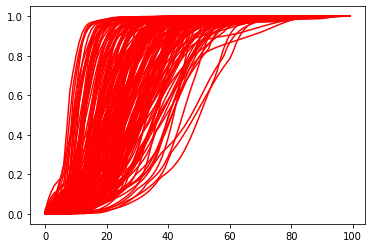

In [35]:
dataset = 'bgpd'
main_img = 'FLAIR.nii.gz'
label_name = 'mask_GTV_FLAIR.nii.gz'
mask_name = 'FLAIR_mask.nii.gz'
root = Path('/anvar/public_datasets/preproc_study/{}/6_hist/6_hist_fold_0/'.format(dataset)) 

for patient in tqdm(root.glob('*')):
    if patient.is_dir():
        img = nibabel.load(patient / main_img).get_fdata()
        mask = nibabel.load(patient / label_name).get_fdata()
        brain = nibabel.load('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset) +
                             str(patient).split('/')[-1] +'/' + mask_name).get_fdata()
        
        cdf_brain, cdf_healthy, cdf_tumor, _bins = compute_cdf(img, brain, mask, _bin_heuristics = 100)
        plt.plot(cdf_brain, 'r')
plt.show()

180it [02:56,  1.02it/s]


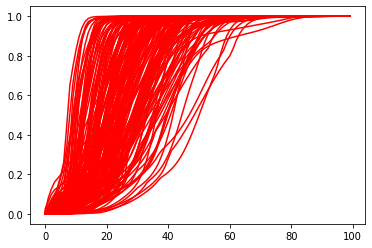

In [38]:
dataset = 'bgpd'
main_img = 'FLAIR.nii.gz'
label_name = 'mask_GTV_FLAIR.nii.gz'
mask_name = 'FLAIR_mask.nii.gz'
root = Path('/anvar/public_datasets/preproc_study/{}/6_hist/6_hist_fold_0/'.format(dataset)) 

for patient in tqdm(root.glob('*')):
    if patient.is_dir():
        img = nibabel.load(patient / main_img).get_fdata()
        mask = nibabel.load(patient / label_name).get_fdata()
        brain = nibabel.load('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset) +
                             str(patient).split('/')[-1] +'/' + mask_name).get_fdata()
        
        cdf_brain, cdf_healthy, cdf_tumor, _bins = compute_cdf(img, brain, mask, _bin_heuristics = 100)
        plt.plot(cdf_healthy, 'r')
plt.show()

180it [02:51,  1.05it/s]


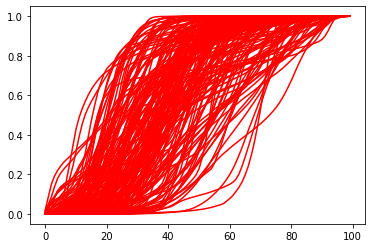

In [39]:
dataset = 'bgpd'
main_img = 'FLAIR.nii.gz'
label_name = 'mask_GTV_FLAIR.nii.gz'
mask_name = 'FLAIR_mask.nii.gz'
root = Path('/anvar/public_datasets/preproc_study/{}/6_hist/6_hist_fold_0/'.format(dataset)) 

for patient in tqdm(root.glob('*')):
    if patient.is_dir():
        img = nibabel.load(patient / main_img).get_fdata()
        mask = nibabel.load(patient / label_name).get_fdata()
        brain = nibabel.load('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset) +
                             str(patient).split('/')[-1] +'/' + mask_name).get_fdata()
        
        cdf_brain, cdf_healthy, cdf_tumor, _bins = compute_cdf(img, brain, mask, _bin_heuristics = 100)
        plt.plot(cdf_tumor, 'r')
plt.show()